# Sign Language Image Classification with Vision Transformers

### Dataset Preprocessing  for Vision Transformer (ViT) Model

### **Load Dataset**
   - The dataset is loaded using Keras's `image_dataset_from_directory` function.
   - Images are resized to 224x224 to match the input size of the ViT model.

### **Model and Feature Extractor Loading**:
   - The Vision Transformer model `vit-tiny-patch16` is loaded from the `transformers` library.
   - The corresponding feature extractor is also loaded to preprocess images for the model.

### **Preprocessing**:
   - A `preprocess_vit` function applies the feature extractor transformations to normalize and prepare images for the ViT model.
   - The dataset is mapped to this preprocessing function with parallelization for improved performance.

### **Dataset Splitting**:
   - The dataset is split into training (70%), validation (10%), and testing (20%) subsets.


### Install packages

### Import packages

In [1]:
import os

# Set up dataset path and name
kaggle_dataset = "ardamavi/27-class-sign-language-dataset"
dataset_dir = "./sign-language-dataset"  # Path to store the dataset

# Ensure the dataset directory exists
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)
    print("Downloading dataset from Kaggle...")

    # Download and unzip the dataset
    os.system(f"kaggle datasets download -d {kaggle_dataset} -p {dataset_dir} --unzip")
    print("Dataset downloaded and unzipped.")
else:
    print("Dataset already downloaded.")


Dataset downloaded and unzipped.


In [2]:
# Import necessary libraries
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from datasets import load_dataset
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from timm import create_model
from tqdm import tqdm
import numpy as np
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder

In [3]:
from datasets import load_dataset

# X_path = r"D:\Master\DNN\sign-language-image-detection\src\ViT\sign-datasets\sign_datasets\27-class-sign-language\X.npy"
# Y_path = r"D:\Master\DNN\sign-language-image-detection\src\ViT\sign-datasets\sign_datasets\27-class-sign-language\Y.npy"

# X_path = os.path.join(dataset_dir, 'X.npy')
# Y_path = os.path.join(dataset_dir, 'Y.npy')

# dataset = NPYDataset(X_path, Y_path)

# Load data
X = np.load(os.path.join(dataset_dir, "X.npy"))  # Image data as numpy array
Y = np.load(os.path.join(dataset_dir, "Y.npy"))  # Labels

# Convert labels to integer encoding
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y.flatten())  # Flatten ensures correct format



In [4]:
class NPYDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]  # (128, 128, 3)
        label = self.labels[idx]

        # Convert NumPy image (H, W, C) to PIL Image
        image = transforms.functional.to_pil_image(image)

        if self.transform:
            image = self.transform(image)

        return image, label

## Load dataset

In [5]:
mean = [0.5108343362808228, 0.47160401940345764, 0.43902790546417236]
std = [0.5867133736610413, 0.5466195344924927, 0.5143911242485046] 

In [6]:
transform_final = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),  
    transforms.Normalize(
        mean=mean,  
        std=std
    )
])

In [7]:
dataset_final = NPYDataset(X, Y_encoded, transform=transform_final)


In [8]:
total_size = len(dataset_final)
train_size = int(0.7 * total_size)  # 70% Training
val_size = int(0.2 * total_size)  # 20% Validation
test_size = total_size - train_size - val_size  # 10% Testing

train_split, val_split, test_split = random_split(dataset_final, [train_size, val_size, test_size])

# --------------- Step 7: Create DataLoaders ------------------
batch_size = 64

train_loader_resized = DataLoader(train_split, batch_size=batch_size, shuffle=True)
val_loader_resized = DataLoader(val_split, batch_size=batch_size, shuffle=False)
test_loader_resized = DataLoader(test_split, batch_size=batch_size, shuffle=False)


In [9]:
num_classes = len(label_encoder.classes_)
print(f"Number of classes: {num_classes}")

Number of classes: 27


In [10]:
import matplotlib.pyplot as plt
from collections import Counter

# Function to plot class distribution with enhanced visualization
def plot_class_distribution(dataset, title):
    # Count occurrences of each class
    class_counts = Counter([dataset[i][1] for i in range(len(dataset))])
    
    # Sort class labels and counts
    labels, counts = zip(*sorted(class_counts.items()))
    
    # Create a larger figure for better visibility
    plt.figure(figsize=(12, 6))  # Set figure size (adjust as needed)
    
    # Plot the distribution
    plt.bar(labels, counts, tick_label=[str(label) for label in labels], color='skyblue')
    plt.xlabel('Class Labels', fontsize=14)
    plt.ylabel('Number of Samples', fontsize=14)
    plt.title(title, fontsize=16)
    
    # Rotate tick labels for better readability if there are many classes
    plt.xticks( fontsize=12)
    
    # Increase the size of the y-axis labels and ticks for better visibility
    plt.yticks(fontsize=12)
    
    # Display the plot
    plt.tight_layout()  # Adjust layout to fit everything
    plt.show()


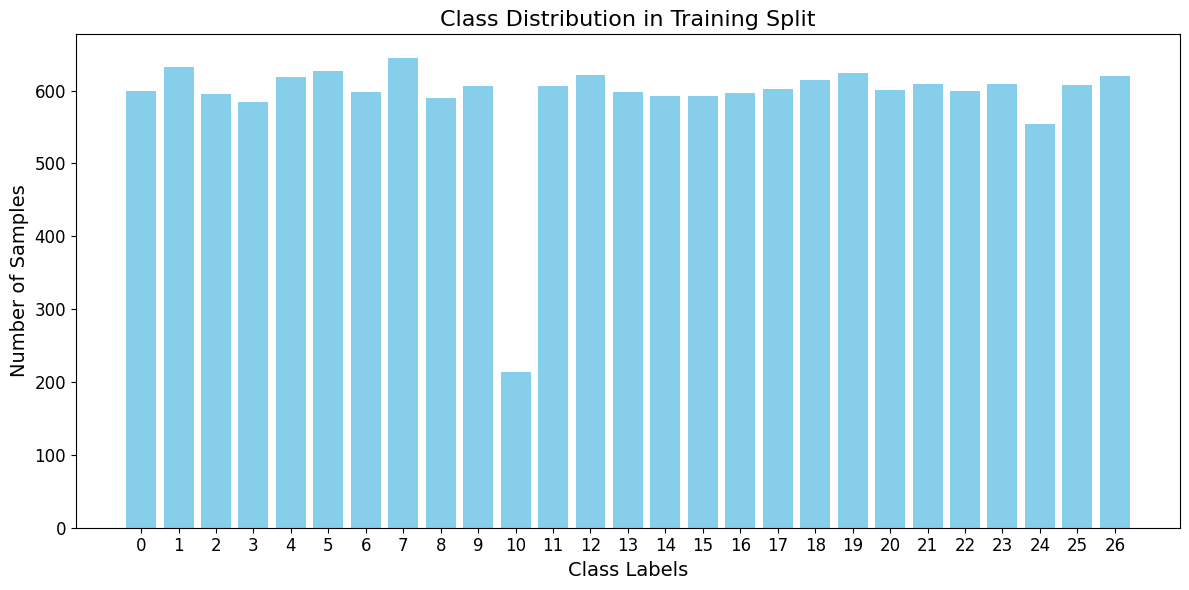

In [11]:
plot_class_distribution(train_split, "Class Distribution in Training Split")

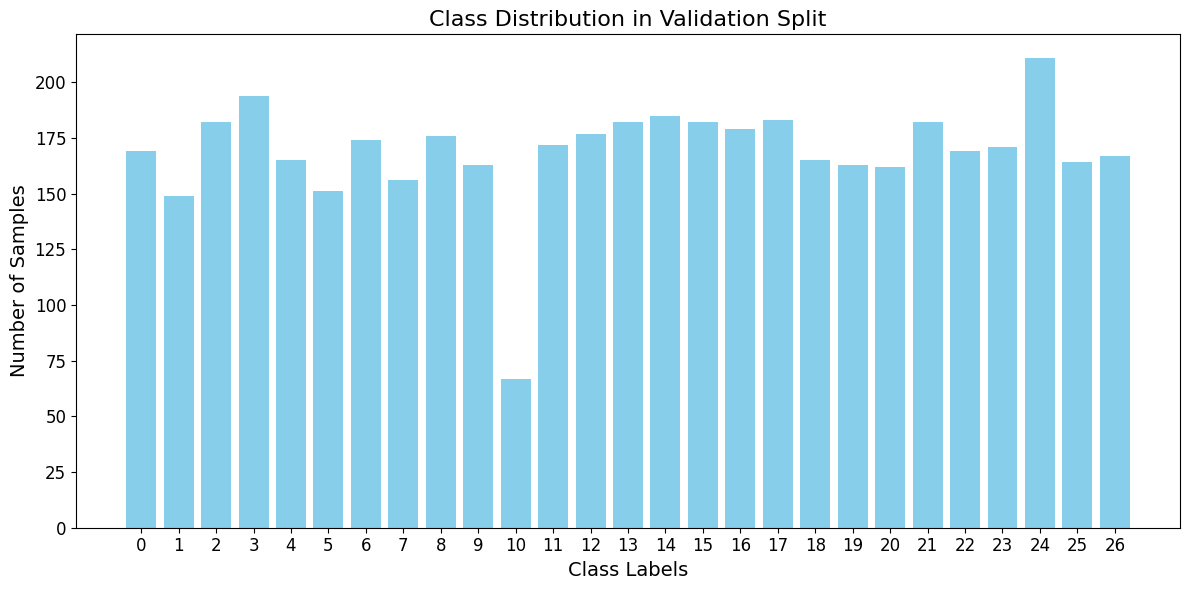

In [12]:
# Plot for validation split
plot_class_distribution(val_split, "Class Distribution in Validation Split")

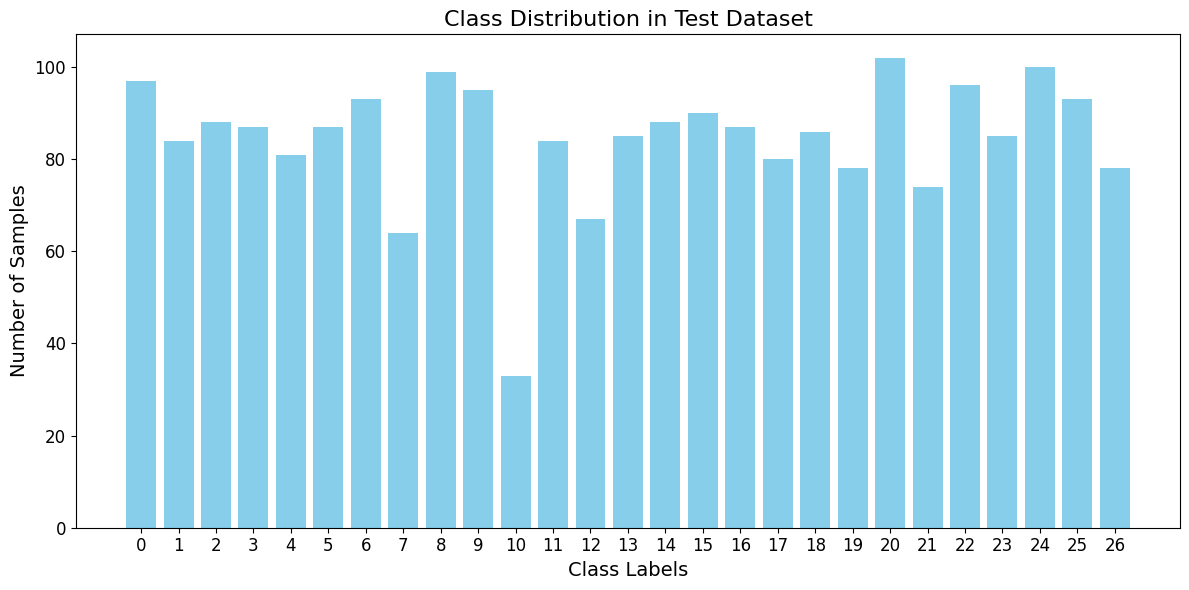

In [13]:
# Plot for test dataset
plot_class_distribution(test_split, "Class Distribution in Test Dataset")

### Model Training - Full Vit Training

#### # Function to compute mean and std
def compute_mean_std(dataloader):
    mean = 0.0
    std = 0.0
    num_samples = 0
    for images, _ in tqdm(dataloader, desc="Computing mean and std"):
        # Check if images are in tensor form (no conversion needed)
        if isinstance(images, torch.Tensor):
            batch_size, channels, height, width = images.shape
            mean += images.mean([0, 2, 3]) * batch_size
            std += images.std([0, 2, 3]) * batch_size
            num_samples += batch_size
        else:
            raise TypeError("Expected tensor but got type: {}".format(type(images)))

    mean /= num_samples
    std /= num_samples
    return mean, std
# Function to compute mean and std
def compute_mean_std(dataloader):
    mean = 0.0
    std = 0.0
    num_samples = 0
    for images, _ in tqdm(dataloader, desc="Computing mean and std"):
        # Check if images are in tensor form (no conversion needed)
        if isinstance(images, torch.Tensor):
            batch_size, channels, height, width = images.shape
            mean += images.mean([0, 2, 3]) * batch_size
            std += images.std([0, 2, 3]) * batch_size
            num_samples += batch_size
        else:
            raise TypeError("Expected tensor but got type: {}".format(type(images)))

    mean /= num_samples
    std /= num_samples
    return mean, std
Trainer Class

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()


In [9]:
from tqdm import tqdm
import torch

class Trainer:
    def __init__(self, model, optimizer, loss_fn, device, scheduler=None):
        """
        Initialize the Trainer class.

        Args:
            model (torch.nn.Module): The model to train.
            optimizer (torch.optim.Optimizer): Optimizer for updating weights.
            loss_fn (torch.nn.Module): Loss function.
            device (torch.device): Device to run training (CPU/GPU).
            scheduler (torch.optim.lr_scheduler, optional): Learning rate scheduler. Default is None.
        """
        self.model = model.to(device)
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.device = device
        self.scheduler = scheduler  # Optional scheduler

    def train_epoch(self, train_loader):
        """Train for one epoch and return loss and accuracy."""
        self.model.train()
        total_loss = 0
        correct = 0

        with tqdm(train_loader, desc="Training", unit="batch") as t:
            for images, labels in t:
                images, labels = images.to(self.device), labels.to(self.device)
                self.optimizer.zero_grad()
                logits = self.model(images)
                loss = self.loss_fn(logits, labels)
                loss.backward()
                self.optimizer.step()

                # Track loss and correct predictions
                total_loss += loss.item() * len(images)
                predictions = torch.argmax(logits, dim=1)
                correct += (predictions == labels).sum().item()

                t.set_postfix(loss=loss.item())
        
        # Compute average loss and accuracy
        avg_loss = total_loss / len(train_loader.dataset)
        accuracy = correct / len(train_loader.dataset)
        return avg_loss, accuracy

    @torch.no_grad()
    def evaluate(self, dataloader):
        """Evaluate the model and return loss and accuracy."""
        self.model.eval()
        total_loss = 0
        correct = 0

        with tqdm(dataloader, desc="Validating", unit="batch") as t:
            for images, labels in t:
                images, labels = images.to(self.device), labels.to(self.device)
                logits = self.model(images)
                loss = self.loss_fn(logits, labels)

                # Track loss and correct predictions
                total_loss += loss.item() * len(images)
                predictions = torch.argmax(logits, dim=1)
                correct += (predictions == labels).sum().item()

        # Compute average loss and accuracy
        avg_loss = total_loss / len(dataloader.dataset)
        accuracy = correct / len(dataloader.dataset)
        return avg_loss, accuracy

    def get_current_lr(self):
        """Retrieve the current learning rate from the optimizer."""
        return self.optimizer.param_groups[0]['lr']

    def train(self, train_loader, val_loader, epochs):
        """Train the model and evaluate it after each epoch."""
        train_losses, train_accuracies = [], []
        val_losses, val_accuracies = [], []
        learning_rates = []  # Track learning rate for each epoch

        for epoch in range(epochs):
            print(f"Epoch {epoch + 1}/{epochs}")
            
            # Training phase
            train_loss, train_accuracy = self.train_epoch(train_loader)
            train_losses.append(train_loss)
            train_accuracies.append(train_accuracy)
            
            # Validation phase
            val_loss, val_accuracy = self.evaluate(val_loader)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
            
            # Get the learning rate
            current_lr = self.get_current_lr()
            learning_rates.append(current_lr)
            
            # Print epoch metrics
            print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
            print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
            print(f"Learning Rate: {current_lr:.6f}")
            
            # Step the scheduler, if provided
            if self.scheduler:
                self.scheduler.step(val_loss)  # Use validation loss for ReduceLROnPlateau
            
            torch.cuda.empty_cache()

        return train_losses, train_accuracies, val_losses, val_accuracies, learning_rates




In [16]:
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn as nn
from timm import create_model
import time

# Load the pre-trained ViT-Tiny model from timm
model = create_model(
    "vit_tiny_patch16_224",  # Pre-trained ViT-Tiny on ImageNet-1k
    pretrained=True,         # Load pre-trained weights
    num_classes=num_classes  # Use dynamic number of classes
)


# Unfreeze the entire model (train all layers)
for param in model.parameters():
    param.requires_grad = True

# Define optimizer with adjusted learning rate and weight decay
optimizer = optim.AdamW(
    model.parameters(), lr=2e-4, weight_decay=1e-2
)

# Define CrossEntropy loss function
loss_fn = nn.CrossEntropyLoss()


# Define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
model = model.to(device)

# Train the full ViT model
trainer = Trainer(model, optimizer, loss_fn, device, scheduler=None)
start_time = time.time()
train_losses, train_accuracies, val_losses, val_accuracies, learning_rates = trainer.train(
    train_loader_resized, val_loader_resized, epochs=2
)
# End timer after training
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
# Print learning rates for each epoch
print("Learning rates per epoch:", learning_rates)
print(f"Training completed in: {elapsed_time:.2f} seconds")

model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

Epoch 1/2


Validating: 100%|██████████| 72/72 [00:14<00:00,  4.83batch/s]


Train Loss: 0.5363, Train Accuracy: 0.8403
Validation Loss: 0.1356, Validation Accuracy: 0.9579
Learning Rate: 0.000200
Epoch 2/2


Validating: 100%|██████████| 72/72 [00:15<00:00,  4.76batch/s]

Train Loss: 0.0852, Train Accuracy: 0.9753
Validation Loss: 0.1168, Validation Accuracy: 0.9671
Learning Rate: 0.000200
Learning rates per epoch: [0.0002, 0.0002]
Training completed in: 205.77 seconds


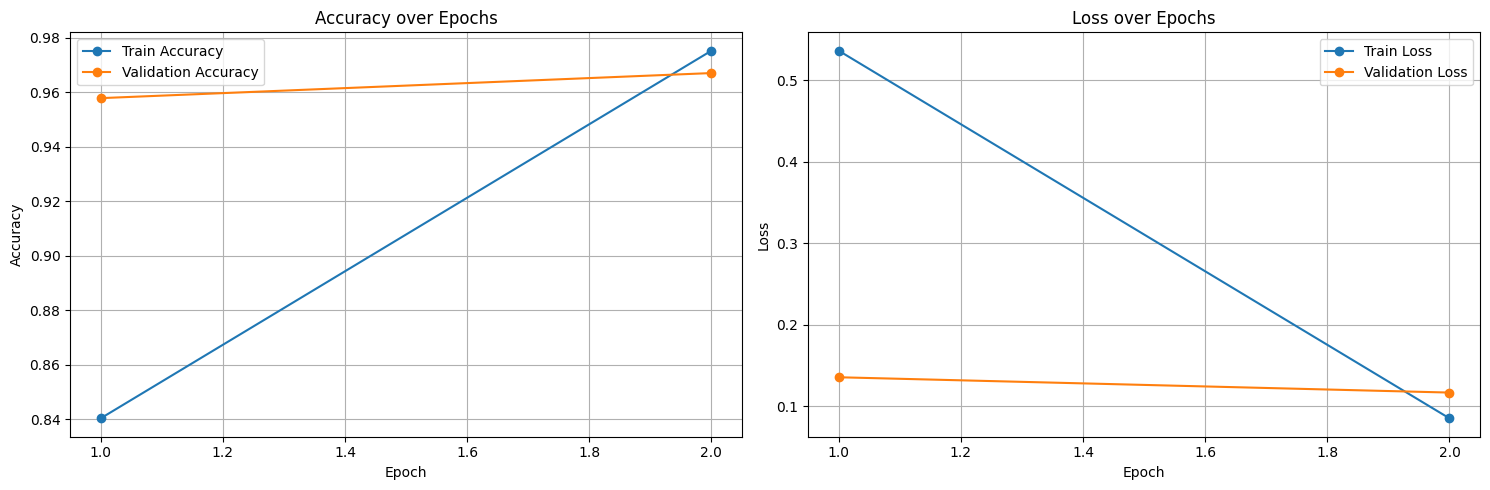

In [17]:
import matplotlib.pyplot as plt

# Create subplots: one for accuracy and one for loss
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot train and validation accuracy
axes[0].plot(range(1, len(train_accuracies) + 1), train_accuracies, marker='o', label="Train Accuracy")
axes[0].plot(range(1, len(val_accuracies) + 1), val_accuracies, marker='o', label="Validation Accuracy")
axes[0].set_title("Accuracy over Epochs")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].grid(True)
axes[0].legend()

# Plot train and validation loss
axes[1].plot(range(1, len(train_losses) + 1), train_losses, marker='o', label="Train Loss")
axes[1].plot(range(1, len(val_losses) + 1), val_losses, marker='o', label="Validation Loss")
axes[1].set_title("Loss over Epochs")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].grid(True)
axes[1].legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

In [18]:
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate predictions and true labels
y_true_classifier = []
y_pred_classifier = []
class_names = label_encoder.classes_  # Automatically get class names from dataset

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for images, labels in val_loader_resized:  # Use the validation DataLoader
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        predictions = torch.argmax(logits, dim=1)
        y_true_classifier.extend(labels.cpu().numpy())
        y_pred_classifier.extend(predictions.cpu().numpy())

# Calculate confusion matrix
cm = confusion_matrix(y_true_classifier, y_pred_classifier)





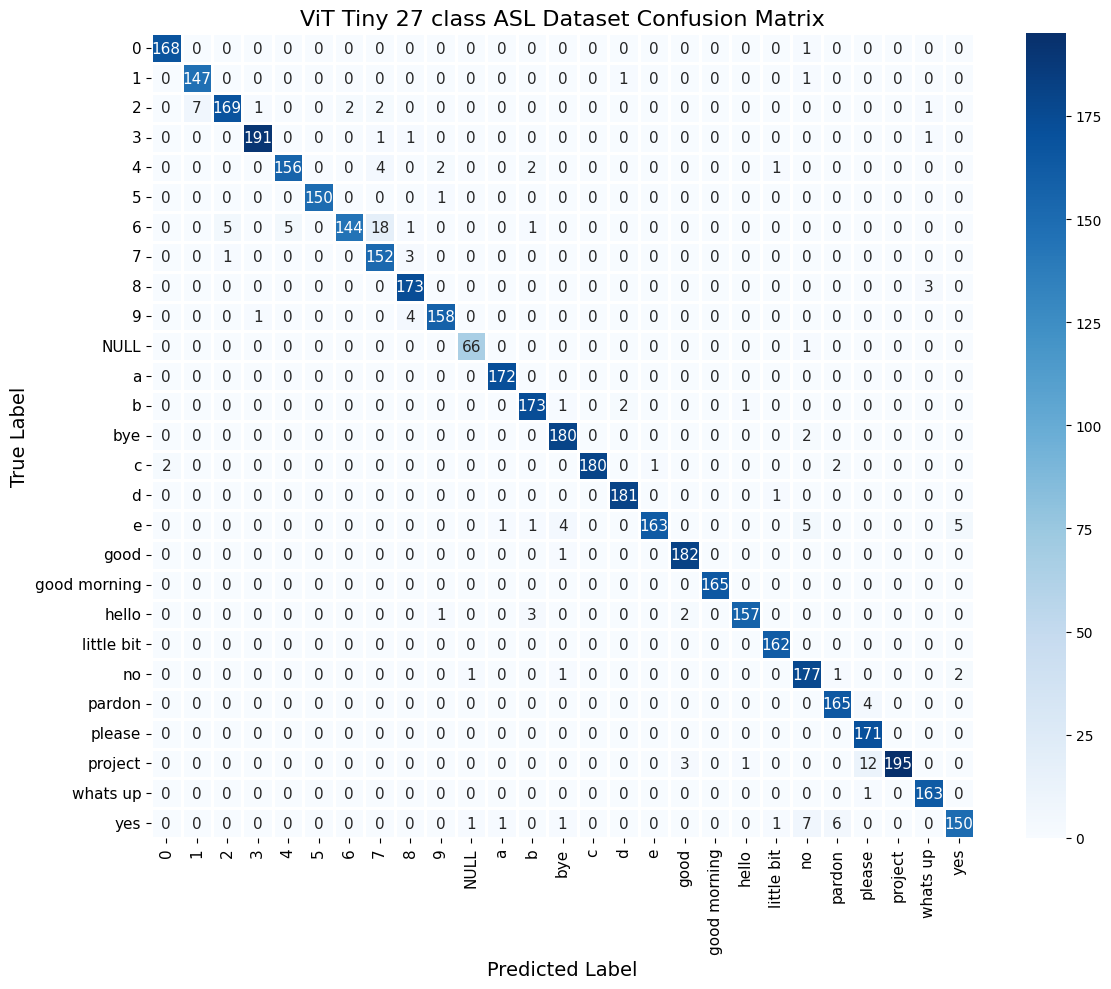

In [19]:
# Plot the confusion matrix with a larger figure size and bigger margins
plt.figure(figsize=(12, 10))  # Adjust the figsize to make the plot larger
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=True,
            annot_kws={"size": 11}, linewidths=1.8)  # Increase linewidth for better visibility of borders
plt.title("ViT Tiny 27 class ASL Dataset Confusion Matrix", fontsize=16)  # Increase font size of the title
plt.xlabel("Predicted Label", fontsize=14)  # Increase font size of the x-axis label
plt.ylabel("True Label", fontsize=14)  # Increase font size of the y-axis label
plt.xticks(fontsize=11)  # Set x-tick font size
plt.yticks(fontsize=11)

# Adjust the padding around the plot and labels
plt.subplots_adjust(left=0.2, right=0.8, top=0.85, bottom=0.15)  # Adjust the plot margins
plt.tight_layout()  # Ensure everything fits nicely within the plot area
plt.show()


In [20]:
test_loss, test_accuracy = trainer.evaluate(test_loader_resized)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Validating: 100%|██████████| 36/36 [00:06<00:00,  5.72batch/s]

Test Loss: 0.1335, Test Accuracy: 0.9601


In [31]:
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn as nn
from timm import create_model
import torch.optim as optim
import time
# Load the pre-trained ViT-Tiny model from timm
model = create_model(
    "vit_tiny_patch16_224",  # Pre-trained ViT-Tiny on ImageNet-1k
    pretrained=True,         # Load pre-trained weights
    num_classes=num_classes  # Use dynamic number of classes
)

# Freeze all layers except the classifier head
for param in model.parameters():
    param.requires_grad = False

# Only unfreeze the classifier head
for param in model.head.parameters():
    param.requires_grad = True


# Define optimizer with adjusted learning rate and weight decay
optimizer = optim.AdamW(
    model.parameters(), lr=1e-3, weight_decay=1e-3
)
# Define CrossEntropy loss function
loss_fn = nn.CrossEntropyLoss()


# Define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
model = model.to(device)

# Train only the classifier head
trainer = Trainer(model, optimizer, loss_fn, device)
start_time = time.time()

train_losses, train_accuracies, val_losses, val_accuracies, learning_rates = trainer.train(
    train_loader_resized, val_loader_resized, epochs=23
)

# End timer after training
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
# Print learning rates for each epoch
print("Learning rates per epoch:", learning_rates)
print(f"Training completed in: {elapsed_time:.2f} seconds")

Epoch 1/23


Validating: 100%|██████████| 72/72 [00:12<00:00,  5.76batch/s]


Train Loss: 2.3139, Train Accuracy: 0.3106
Validation Loss: 1.8469, Validation Accuracy: 0.4432
Learning Rate: 0.001000
Epoch 2/23


Validating: 100%|██████████| 72/72 [00:12<00:00,  5.62batch/s]


Train Loss: 1.6894, Train Accuracy: 0.4830
Validation Loss: 1.6371, Validation Accuracy: 0.4943
Learning Rate: 0.001000
Epoch 3/23


Validating: 100%|██████████| 72/72 [00:12<00:00,  5.67batch/s]


Train Loss: 1.5112, Train Accuracy: 0.5313
Validation Loss: 1.5472, Validation Accuracy: 0.5088
Learning Rate: 0.001000
Epoch 4/23


Validating: 100%|██████████| 72/72 [00:12<00:00,  5.55batch/s]


Train Loss: 1.4190, Train Accuracy: 0.5575
Validation Loss: 1.4834, Validation Accuracy: 0.5246
Learning Rate: 0.001000
Epoch 5/23


Validating: 100%|██████████| 72/72 [00:12<00:00,  5.63batch/s]


Train Loss: 1.3626, Train Accuracy: 0.5706
Validation Loss: 1.4386, Validation Accuracy: 0.5395
Learning Rate: 0.001000
Epoch 6/23


Validating: 100%|██████████| 72/72 [00:13<00:00,  5.53batch/s]


Train Loss: 1.3174, Train Accuracy: 0.5811
Validation Loss: 1.4194, Validation Accuracy: 0.5432
Learning Rate: 0.001000
Epoch 7/23


Validating: 100%|██████████| 72/72 [00:12<00:00,  5.68batch/s]


Train Loss: 1.2851, Train Accuracy: 0.5908
Validation Loss: 1.4086, Validation Accuracy: 0.5465
Learning Rate: 0.001000
Epoch 8/23


Validating: 100%|██████████| 72/72 [00:12<00:00,  5.66batch/s]


Train Loss: 1.2624, Train Accuracy: 0.5953
Validation Loss: 1.3963, Validation Accuracy: 0.5469
Learning Rate: 0.001000
Epoch 9/23


Validating: 100%|██████████| 72/72 [00:12<00:00,  5.64batch/s]


Train Loss: 1.2510, Train Accuracy: 0.5934
Validation Loss: 1.3896, Validation Accuracy: 0.5496
Learning Rate: 0.001000
Epoch 10/23


Validating: 100%|██████████| 72/72 [00:12<00:00,  5.67batch/s]


Train Loss: 1.2284, Train Accuracy: 0.6035
Validation Loss: 1.3945, Validation Accuracy: 0.5478
Learning Rate: 0.001000
Epoch 11/23


Validating: 100%|██████████| 72/72 [00:12<00:00,  5.60batch/s]


Train Loss: 1.2140, Train Accuracy: 0.6069
Validation Loss: 1.3767, Validation Accuracy: 0.5507
Learning Rate: 0.001000
Epoch 12/23


Validating: 100%|██████████| 72/72 [00:12<00:00,  5.62batch/s]


Train Loss: 1.2079, Train Accuracy: 0.6051
Validation Loss: 1.3816, Validation Accuracy: 0.5443
Learning Rate: 0.001000
Epoch 13/23


Validating: 100%|██████████| 72/72 [00:12<00:00,  5.73batch/s]


Train Loss: 1.1976, Train Accuracy: 0.6100
Validation Loss: 1.3563, Validation Accuracy: 0.5627
Learning Rate: 0.001000
Epoch 14/23


Validating: 100%|██████████| 72/72 [00:12<00:00,  5.70batch/s]


Train Loss: 1.1890, Train Accuracy: 0.6101
Validation Loss: 1.3626, Validation Accuracy: 0.5605
Learning Rate: 0.001000
Epoch 15/23


Validating: 100%|██████████| 72/72 [00:12<00:00,  5.65batch/s]


Train Loss: 1.1792, Train Accuracy: 0.6157
Validation Loss: 1.3781, Validation Accuracy: 0.5535
Learning Rate: 0.001000
Epoch 16/23


Validating: 100%|██████████| 72/72 [00:12<00:00,  5.72batch/s]


Train Loss: 1.1731, Train Accuracy: 0.6182
Validation Loss: 1.3794, Validation Accuracy: 0.5570
Learning Rate: 0.001000
Epoch 17/23


Validating: 100%|██████████| 72/72 [00:12<00:00,  5.69batch/s]


Train Loss: 1.1674, Train Accuracy: 0.6167
Validation Loss: 1.3818, Validation Accuracy: 0.5520
Learning Rate: 0.001000
Epoch 18/23


Validating: 100%|██████████| 72/72 [00:12<00:00,  5.61batch/s]


Train Loss: 1.1656, Train Accuracy: 0.6170
Validation Loss: 1.3677, Validation Accuracy: 0.5579
Learning Rate: 0.001000
Epoch 19/23


Validating: 100%|██████████| 72/72 [00:12<00:00,  5.76batch/s]


Train Loss: 1.1600, Train Accuracy: 0.6209
Validation Loss: 1.3760, Validation Accuracy: 0.5555
Learning Rate: 0.001000
Epoch 20/23


Validating: 100%|██████████| 72/72 [00:12<00:00,  5.71batch/s]


Train Loss: 1.1547, Train Accuracy: 0.6191
Validation Loss: 1.3689, Validation Accuracy: 0.5660
Learning Rate: 0.001000
Epoch 21/23


Validating: 100%|██████████| 72/72 [00:12<00:00,  5.73batch/s]


Train Loss: 1.1507, Train Accuracy: 0.6214
Validation Loss: 1.3564, Validation Accuracy: 0.5594
Learning Rate: 0.001000
Epoch 22/23


Validating: 100%|██████████| 72/72 [00:12<00:00,  5.70batch/s]


Train Loss: 1.1479, Train Accuracy: 0.6234
Validation Loss: 1.3822, Validation Accuracy: 0.5570
Learning Rate: 0.001000
Epoch 23/23


Validating: 100%|██████████| 72/72 [00:12<00:00,  5.62batch/s]

Train Loss: 1.1470, Train Accuracy: 0.6246
Validation Loss: 1.3530, Validation Accuracy: 0.5656
Learning Rate: 0.001000
Learning rates per epoch: [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]
Training completed in: 1329.13 seconds


In [33]:
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate predictions and true labels
y_true_classifier = []
y_pred_classifier = []
class_names = label_encoder.classes_  # Automatically get class names from dataset

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for images, labels in val_loader_resized:  # Use the validation DataLoader
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        predictions = torch.argmax(logits, dim=1)
        y_true_classifier.extend(labels.cpu().numpy())
        y_pred_classifier.extend(predictions.cpu().numpy())

# Calculate confusion matrix
cm = confusion_matrix(y_true_classifier, y_pred_classifier)



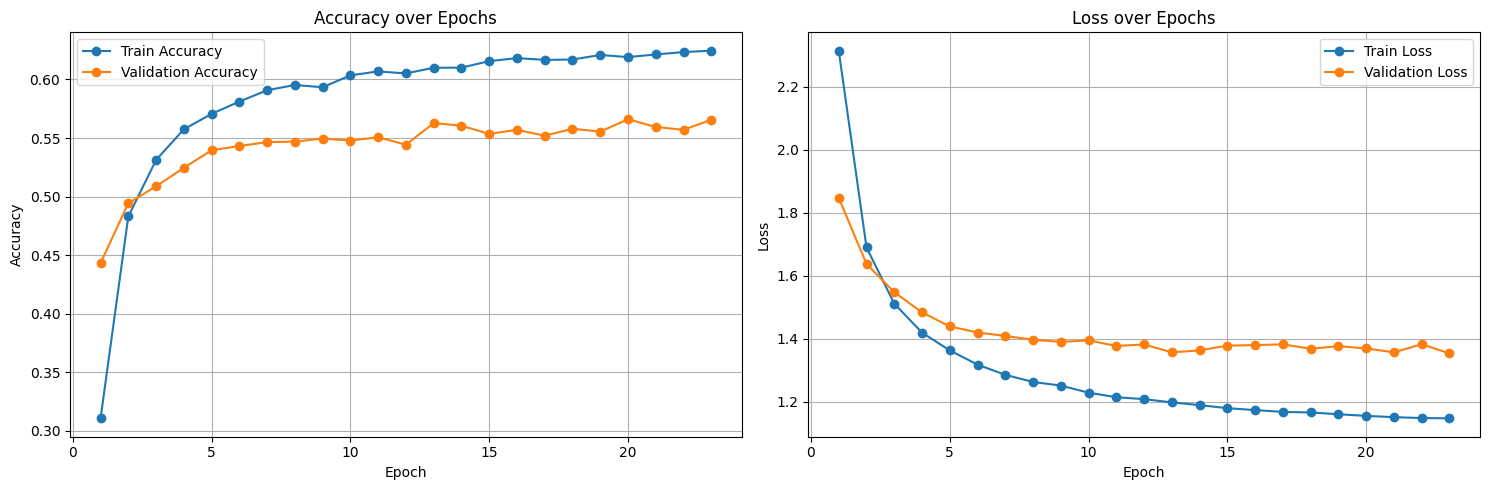

In [34]:
import matplotlib.pyplot as plt

# Create subplots: one for accuracy and one for loss
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot train and validation accuracy
axes[0].plot(range(1, len(train_accuracies) + 1), train_accuracies, marker='o', label="Train Accuracy")
axes[0].plot(range(1, len(val_accuracies) + 1), val_accuracies, marker='o', label="Validation Accuracy")
axes[0].set_title("Accuracy over Epochs")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].grid(True)
axes[0].legend()

# Plot train and validation loss
axes[1].plot(range(1, len(train_losses) + 1), train_losses, marker='o', label="Train Loss")
axes[1].plot(range(1, len(val_losses) + 1), val_losses, marker='o', label="Validation Loss")
axes[1].set_title("Loss over Epochs")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].grid(True)
axes[1].legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

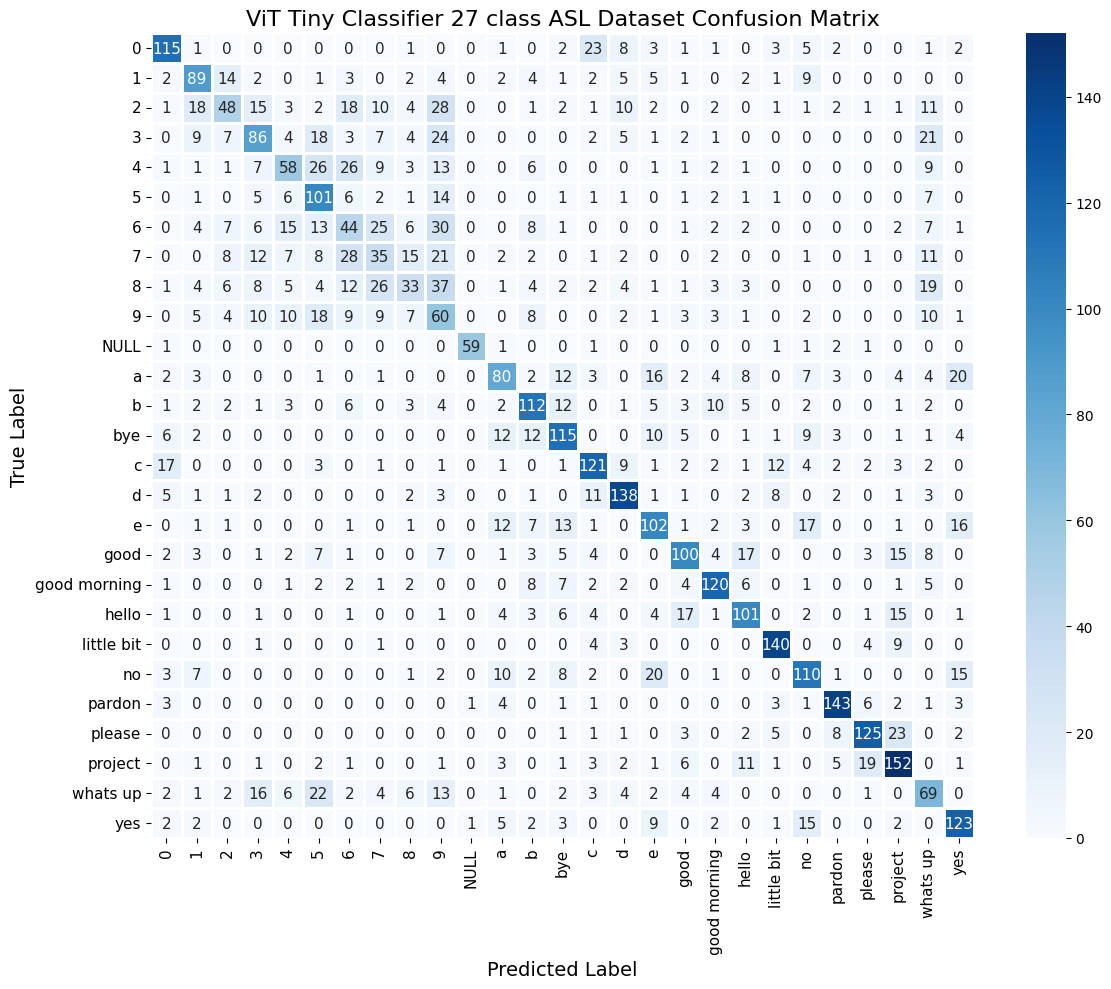

In [35]:
# Plot the confusion matrix with a larger figure size and bigger margins
plt.figure(figsize=(12, 10))  # Adjust the figsize to make the plot larger
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=True,
            annot_kws={"size": 11}, linewidths=1.8)  # Increase linewidth for better visibility of borders
plt.title("ViT Tiny Classifier 27 class ASL Dataset Confusion Matrix", fontsize=16)  # Increase font size of the title
plt.xlabel("Predicted Label", fontsize=14)  # Increase font size of the x-axis label
plt.ylabel("True Label", fontsize=14)  # Increase font size of the y-axis label
plt.xticks(fontsize=11)  # Set x-tick font size
plt.yticks(fontsize=11)

# Adjust the padding around the plot and labels
plt.subplots_adjust(left=0.2, right=0.8, top=0.85, bottom=0.15)  # Adjust the plot margins
plt.tight_layout()  # Ensure everything fits nicely within the plot area
plt.show()

In [36]:
test_loss, test_accuracy = trainer.evaluate(test_loader_resized)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Validating: 100%|██████████| 36/36 [00:06<00:00,  5.56batch/s]

Test Loss: 1.3714, Test Accuracy: 0.5498


In [45]:
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn as nn
from timm import create_model
import torch.optim as optim
import time
# Load the pre-trained ViT-Tiny model from timm
model = create_model(
    "vit_base_patch16_224",  # Pre-trained ViT-Tiny on ImageNet-1k
    pretrained=True,         # Load pre-trained weights
    num_classes=num_classes  # Use dynamic number of classes
)

# Freeze all layers except the classifier head
for param in model.parameters():
    param.requires_grad = False

# Only unfreeze the classifier head
for param in model.head.parameters():
    param.requires_grad = True


# Define optimizer with adjusted learning rate and weight decay
optimizer = optim.AdamW(
    model.parameters(), lr=1e-3, weight_decay=1e-3
)
# Define CrossEntropy loss function
loss_fn = nn.CrossEntropyLoss()


# Define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
model = model.to(device)

# Train only the classifier head
trainer = Trainer(model, optimizer, loss_fn, device)
start_time = time.time()

train_losses, train_accuracies, val_losses, val_accuracies, learning_rates = trainer.train(
    train_loader_resized, val_loader_resized, epochs=15
)

# End timer after training
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
# Print learning rates for each epoch
print("Learning rates per epoch:", learning_rates)
print(f"Training completed in: {elapsed_time:.2f} seconds")

Epoch 1/15


Validating: 100%|██████████| 72/72 [01:02<00:00,  1.14batch/s]


Train Loss: 1.6994, Train Accuracy: 0.4840
Validation Loss: 1.1938, Validation Accuracy: 0.6274
Learning Rate: 0.001000
Epoch 2/15


Validating: 100%|██████████| 72/72 [01:03<00:00,  1.14batch/s]


Train Loss: 1.0192, Train Accuracy: 0.6852
Validation Loss: 0.9851, Validation Accuracy: 0.6871
Learning Rate: 0.001000
Epoch 3/15


Validating: 100%|██████████| 72/72 [01:02<00:00,  1.14batch/s]


Train Loss: 0.8214, Train Accuracy: 0.7496
Validation Loss: 0.8867, Validation Accuracy: 0.7116
Learning Rate: 0.001000
Epoch 4/15


Validating: 100%|██████████| 72/72 [01:03<00:00,  1.14batch/s]


Train Loss: 0.7096, Train Accuracy: 0.7880
Validation Loss: 0.8224, Validation Accuracy: 0.7340
Learning Rate: 0.001000
Epoch 5/15


Validating: 100%|██████████| 72/72 [01:03<00:00,  1.13batch/s]


Train Loss: 0.6390, Train Accuracy: 0.8097
Validation Loss: 0.7630, Validation Accuracy: 0.7542
Learning Rate: 0.001000
Epoch 6/15


Validating: 100%|██████████| 72/72 [01:03<00:00,  1.13batch/s]


Train Loss: 0.5806, Train Accuracy: 0.8268
Validation Loss: 0.7325, Validation Accuracy: 0.7629
Learning Rate: 0.001000
Epoch 7/15


Validating: 100%|██████████| 72/72 [01:03<00:00,  1.14batch/s]


Train Loss: 0.5406, Train Accuracy: 0.8387
Validation Loss: 0.6970, Validation Accuracy: 0.7765
Learning Rate: 0.001000
Epoch 8/15


Validating: 100%|██████████| 72/72 [01:03<00:00,  1.14batch/s]


Train Loss: 0.5006, Train Accuracy: 0.8539
Validation Loss: 0.6788, Validation Accuracy: 0.7825
Learning Rate: 0.001000
Epoch 9/15


Validating: 100%|██████████| 72/72 [01:03<00:00,  1.13batch/s]


Train Loss: 0.4718, Train Accuracy: 0.8632
Validation Loss: 0.6740, Validation Accuracy: 0.7768
Learning Rate: 0.001000
Epoch 10/15


Validating: 100%|██████████| 72/72 [01:03<00:00,  1.13batch/s]


Train Loss: 0.4508, Train Accuracy: 0.8674
Validation Loss: 0.6429, Validation Accuracy: 0.7908
Learning Rate: 0.001000
Epoch 11/15


Validating: 100%|██████████| 72/72 [01:03<00:00,  1.14batch/s]


Train Loss: 0.4275, Train Accuracy: 0.8768
Validation Loss: 0.6519, Validation Accuracy: 0.7862
Learning Rate: 0.001000
Epoch 12/15


Validating: 100%|██████████| 72/72 [01:03<00:00,  1.14batch/s]


Train Loss: 0.4073, Train Accuracy: 0.8806
Validation Loss: 0.6520, Validation Accuracy: 0.7866
Learning Rate: 0.001000
Epoch 13/15


Validating: 100%|██████████| 72/72 [01:03<00:00,  1.14batch/s]


Train Loss: 0.3893, Train Accuracy: 0.8853
Validation Loss: 0.6235, Validation Accuracy: 0.7974
Learning Rate: 0.001000
Epoch 14/15


Validating: 100%|██████████| 72/72 [01:03<00:00,  1.14batch/s]


Train Loss: 0.3751, Train Accuracy: 0.8902
Validation Loss: 0.6391, Validation Accuracy: 0.7862
Learning Rate: 0.001000
Epoch 15/15


Validating: 100%|██████████| 72/72 [01:03<00:00,  1.14batch/s]

Train Loss: 0.3606, Train Accuracy: 0.8949
Validation Loss: 0.6186, Validation Accuracy: 0.7932
Learning Rate: 0.001000
Learning rates per epoch: [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]
Training completed in: 4280.33 seconds


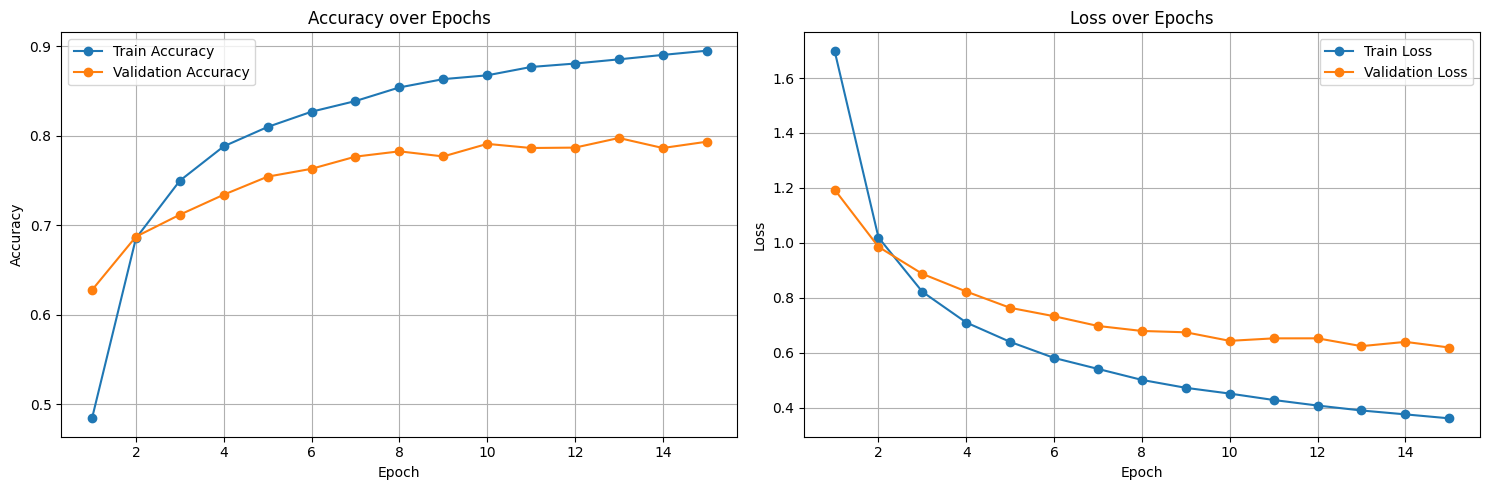

In [46]:
import matplotlib.pyplot as plt

# Create subplots: one for accuracy and one for loss
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot train and validation accuracy
axes[0].plot(range(1, len(train_accuracies) + 1), train_accuracies, marker='o', label="Train Accuracy")
axes[0].plot(range(1, len(val_accuracies) + 1), val_accuracies, marker='o', label="Validation Accuracy")
axes[0].set_title("Accuracy over Epochs")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].grid(True)
axes[0].legend()

# Plot train and validation loss
axes[1].plot(range(1, len(train_losses) + 1), train_losses, marker='o', label="Train Loss")
axes[1].plot(range(1, len(val_losses) + 1), val_losses, marker='o', label="Validation Loss")
axes[1].set_title("Loss over Epochs")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].grid(True)
axes[1].legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

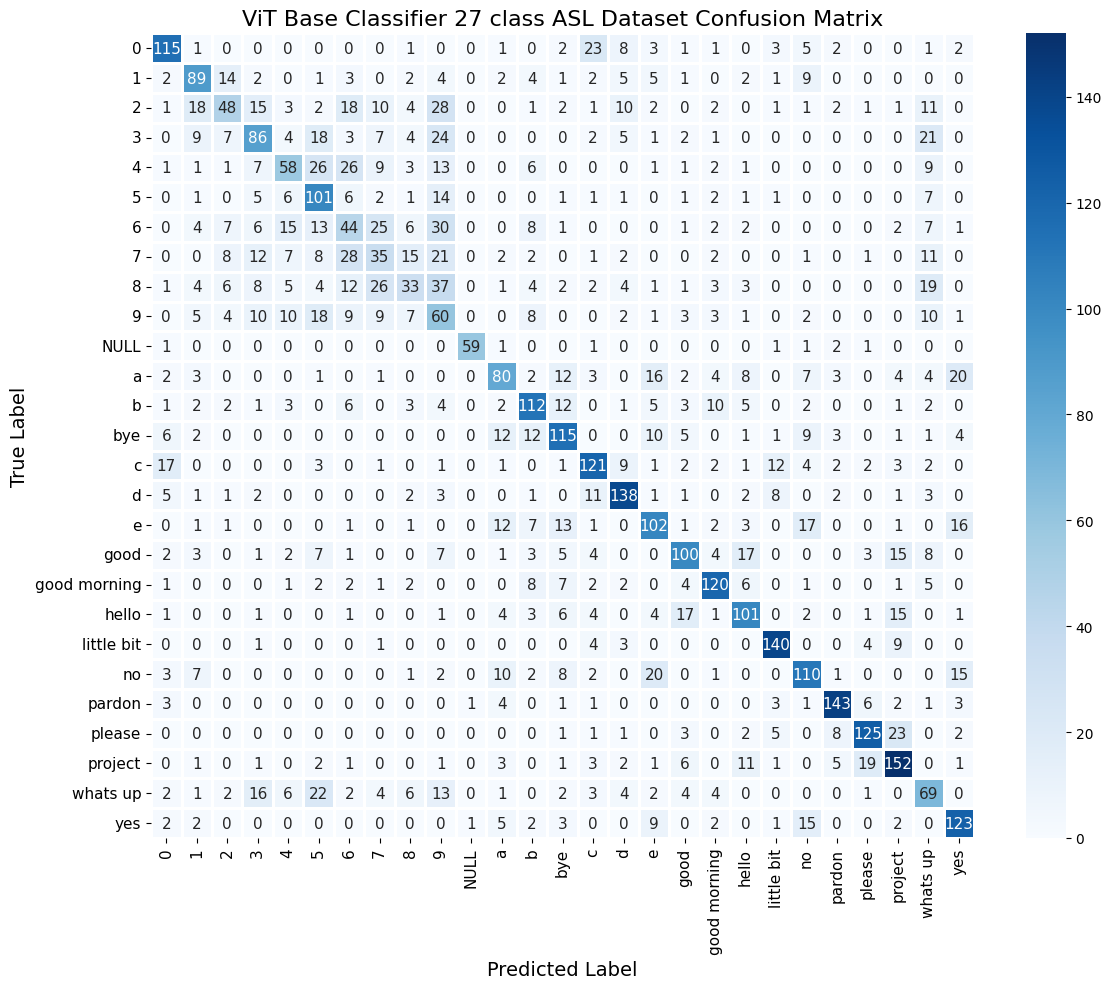

In [48]:
# Plot the confusion matrix with a larger figure size and bigger margins
plt.figure(figsize=(12, 10))  # Adjust the figsize to make the plot larger
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=True,
            annot_kws={"size": 11}, linewidths=1.8)  # Increase linewidth for better visibility of borders
plt.title("ViT Base Classifier 27 class ASL Dataset Confusion Matrix", fontsize=16)  # Increase font size of the title
plt.xlabel("Predicted Label", fontsize=14)  # Increase font size of the x-axis label
plt.ylabel("True Label", fontsize=14)  # Increase font size of the y-axis label
plt.xticks(fontsize=11)  # Set x-tick font size
plt.yticks(fontsize=11)

# Adjust the padding around the plot and labels
plt.subplots_adjust(left=0.2, right=0.8, top=0.85, bottom=0.15)  # Adjust the plot margins
plt.tight_layout()  # Ensure everything fits nicely within the plot area
plt.show()


In [ ]:
# Plot the confusion matrix with a larger figure size and bigger margins
plt.figure(figsize=(12, 10))  # Adjust the figsize to make the plot larger
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=True,
            annot_kws={"size": 11}, linewidths=1.8)  # Increase linewidth for better visibility of borders
plt.title("ViT Base Classifier Gesture Image (Baseline) Confusion Matrix", fontsize=16)  # Increase font size of the title
plt.xlabel("Predicted Label", fontsize=14)  # Increase font size of the x-axis label
plt.ylabel("True Label", fontsize=14)  # Increase font size of the y-axis label
plt.xticks(fontsize=11)  # Set x-tick font size
plt.yticks(fontsize=11)

# Adjust the padding around the plot and labels
plt.subplots_adjust(left=0.2, right=0.8, top=0.85, bottom=0.15)  # Adjust the plot margins
plt.tight_layout()  # Ensure everything fits nicely within the plot area
plt.show()

In [49]:
test_loss, test_accuracy = trainer.evaluate(test_loader_resized)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Validating: 100%|██████████| 36/36 [00:32<00:00,  1.12batch/s]

Test Loss: 0.6344, Test Accuracy: 0.7904


In [20]:
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn as nn
from timm import create_model
import time
# Load the pre-trained ViT-Tiny model from timm
model = create_model(
    "deit3_small_patch16_224.fb_in22k_ft_in1k",  # Pre-trained ViT-Tiny on ImageNet-1k
    pretrained=True,         # Load pre-trained weights
    num_classes=27  # Use dynamic number of classes
)


# Unfreeze the entire model (train all layers)
for param in model.parameters():
    param.requires_grad = True

# Define optimizer with adjusted learning rate and weight decay
optimizer = optim.AdamW(
    model.parameters(), lr=2e-4, weight_decay=1e-2
)

# Define CrossEntropy loss function
loss_fn = nn.CrossEntropyLoss()


# Define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
model = model.to(device)

# Train the full ViT model
trainer = Trainer(model, optimizer, loss_fn, device, scheduler=None)

start_time = time.time()

train_losses, train_accuracies, val_losses, val_accuracies, learning_rates = trainer.train(
    train_loader_resized, val_loader_resized, epochs=2
)

# End timer after training
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print learning rates for each epoch
print("Learning rates per epoch:", learning_rates)
print(f"Training completed in: {elapsed_time:.2f} seconds")

Epoch 1/2


Validating: 100%|██████████| 72/72 [00:21<00:00,  3.29batch/s]


Train Loss: 0.4216, Train Accuracy: 0.8760
Validation Loss: 0.0805, Validation Accuracy: 0.9796
Learning Rate: 0.000200
Epoch 2/2


Validating: 100%|██████████| 72/72 [00:21<00:00,  3.31batch/s]

Train Loss: 0.0755, Train Accuracy: 0.9786
Validation Loss: 0.0820, Validation Accuracy: 0.9787
Learning Rate: 0.000200
Learning rates per epoch: [0.0002, 0.0002]
Training completed in: 412.16 seconds


In [21]:
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate predictions and true labels
y_true_classifier = []
y_pred_classifier = []
class_names = label_encoder.classes_  # Automatically get class names from dataset

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for images, labels in val_loader_resized:  # Use the validation DataLoader
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        predictions = torch.argmax(logits, dim=1)
        y_true_classifier.extend(labels.cpu().numpy())
        y_pred_classifier.extend(predictions.cpu().numpy())

# Calculate confusion matrix
cm = confusion_matrix(y_true_classifier, y_pred_classifier)


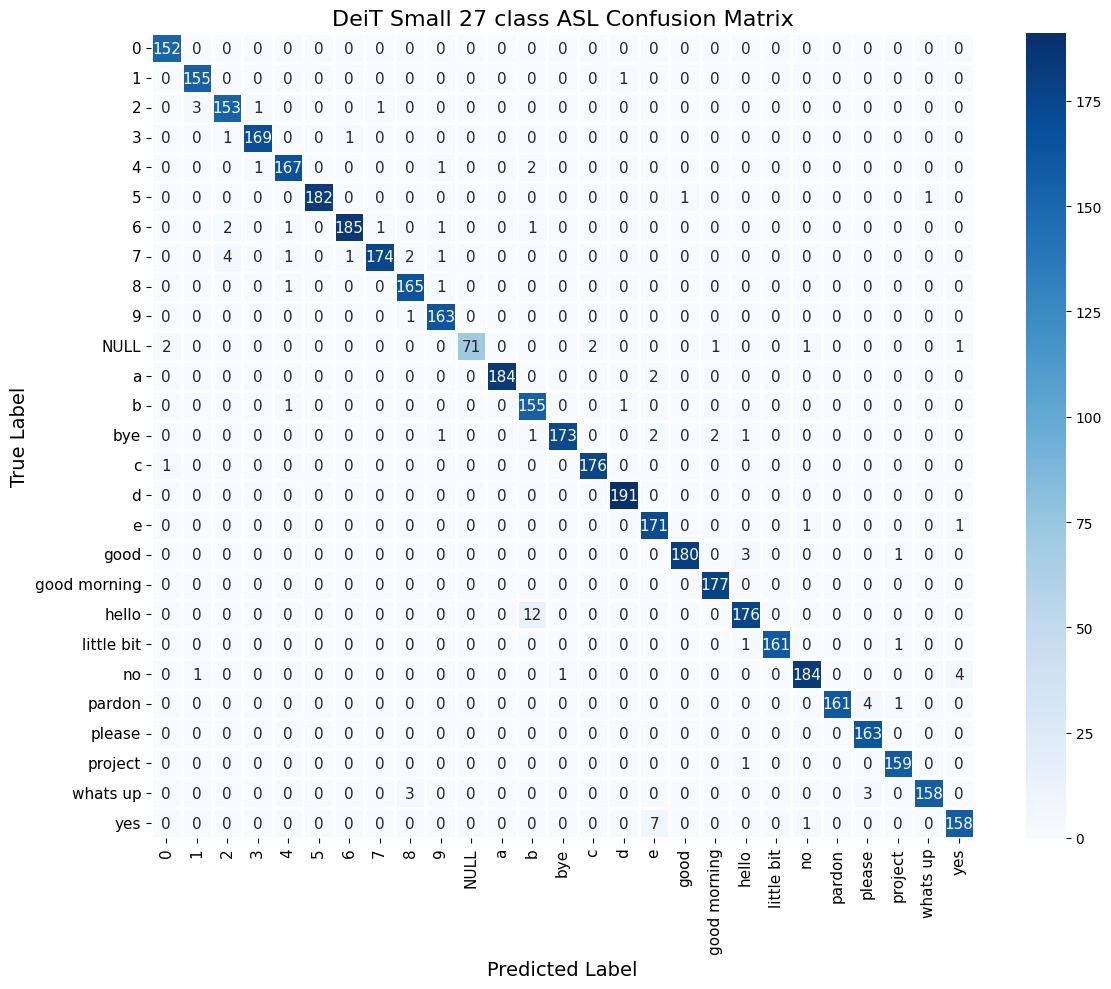

In [22]:
# Plot the confusion matrix with a larger figure size and bigger margins
plt.figure(figsize=(12, 10))  # Adjust the figsize to make the plot larger
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=True,
            annot_kws={"size": 11}, linewidths=1.8)  # Increase linewidth for better visibility of borders
plt.title("DeiT Small 27 class ASL Confusion Matrix", fontsize=16)  # Increase font size of the title
plt.xlabel("Predicted Label", fontsize=14)  # Increase font size of the x-axis label
plt.ylabel("True Label", fontsize=14)  # Increase font size of the y-axis label
plt.xticks(fontsize=11)  # Set x-tick font size
plt.yticks(fontsize=11)

# Adjust the padding around the plot and labels
plt.subplots_adjust(left=0.2, right=0.8, top=0.85, bottom=0.15)  # Adjust the plot margins
plt.tight_layout()  # Ensure everything fits nicely within the plot area
plt.show()

In [23]:
test_loss, test_accuracy = trainer.evaluate(test_loader_resized)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Validating: 100%|██████████| 36/36 [00:10<00:00,  3.28batch/s]

Test Loss: 0.0884, Test Accuracy: 0.9754


In [27]:
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn as nn
from timm import create_model
import time
# Load the pre-trained ViT-Tiny model from timm
model = create_model(
    "efficientvit_m5.r224_in1k",  # Pre-trained ViT-Tiny on ImageNet-1k
    pretrained=True,         # Load pre-trained weights
    num_classes=27  # Use dynamic number of classes
)


# Unfreeze the entire model (train all layers)
for param in model.parameters():
    param.requires_grad = True

# Define optimizer with adjusted learning rate and weight decay
optimizer = optim.AdamW(
    model.parameters(), lr=2e-4, weight_decay=1e-2
)

# Define CrossEntropy loss function
loss_fn = nn.CrossEntropyLoss()


# Define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
model = model.to(device)

# Train the full ViT model
trainer = Trainer(model, optimizer, loss_fn, device, scheduler=None)

start_time = time.time()

train_losses, train_accuracies, val_losses, val_accuracies, learning_rates = trainer.train(
    train_loader_resized, val_loader_resized, epochs=4
)

# End timer after training
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print learning rates for each epoch
print("Learning rates per epoch:", learning_rates)
print(f"Training completed in: {elapsed_time:.2f} seconds")

Epoch 1/4


Validating: 100%|██████████| 72/72 [00:10<00:00,  6.66batch/s]


Train Loss: 2.0247, Train Accuracy: 0.5528
Validation Loss: 0.6965, Validation Accuracy: 0.8814
Learning Rate: 0.000200
Epoch 2/4


Validating: 100%|██████████| 72/72 [00:10<00:00,  6.62batch/s]


Train Loss: 0.3433, Train Accuracy: 0.9389
Validation Loss: 0.1573, Validation Accuracy: 0.9695
Learning Rate: 0.000200
Epoch 3/4


Validating: 100%|██████████| 72/72 [00:11<00:00,  6.52batch/s]


Train Loss: 0.1029, Train Accuracy: 0.9815
Validation Loss: 0.1057, Validation Accuracy: 0.9763
Learning Rate: 0.000200
Epoch 4/4


Validating: 100%|██████████| 72/72 [00:10<00:00,  6.62batch/s]

Train Loss: 0.0587, Train Accuracy: 0.9881
Validation Loss: 0.0788, Validation Accuracy: 0.9800
Learning Rate: 0.000200
Learning rates per epoch: [0.0002, 0.0002, 0.0002, 0.0002]
Training completed in: 299.71 seconds


In [29]:
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate predictions and true labels
y_true_classifier = []
y_pred_classifier = []
class_names = label_encoder.classes_  # Automatically get class names from dataset

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for images, labels in val_loader_resized:  # Use the validation DataLoader
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        predictions = torch.argmax(logits, dim=1)
        y_true_classifier.extend(labels.cpu().numpy())
        y_pred_classifier.extend(predictions.cpu().numpy())

# Calculate confusion matrix
cm = confusion_matrix(y_true_classifier, y_pred_classifier)


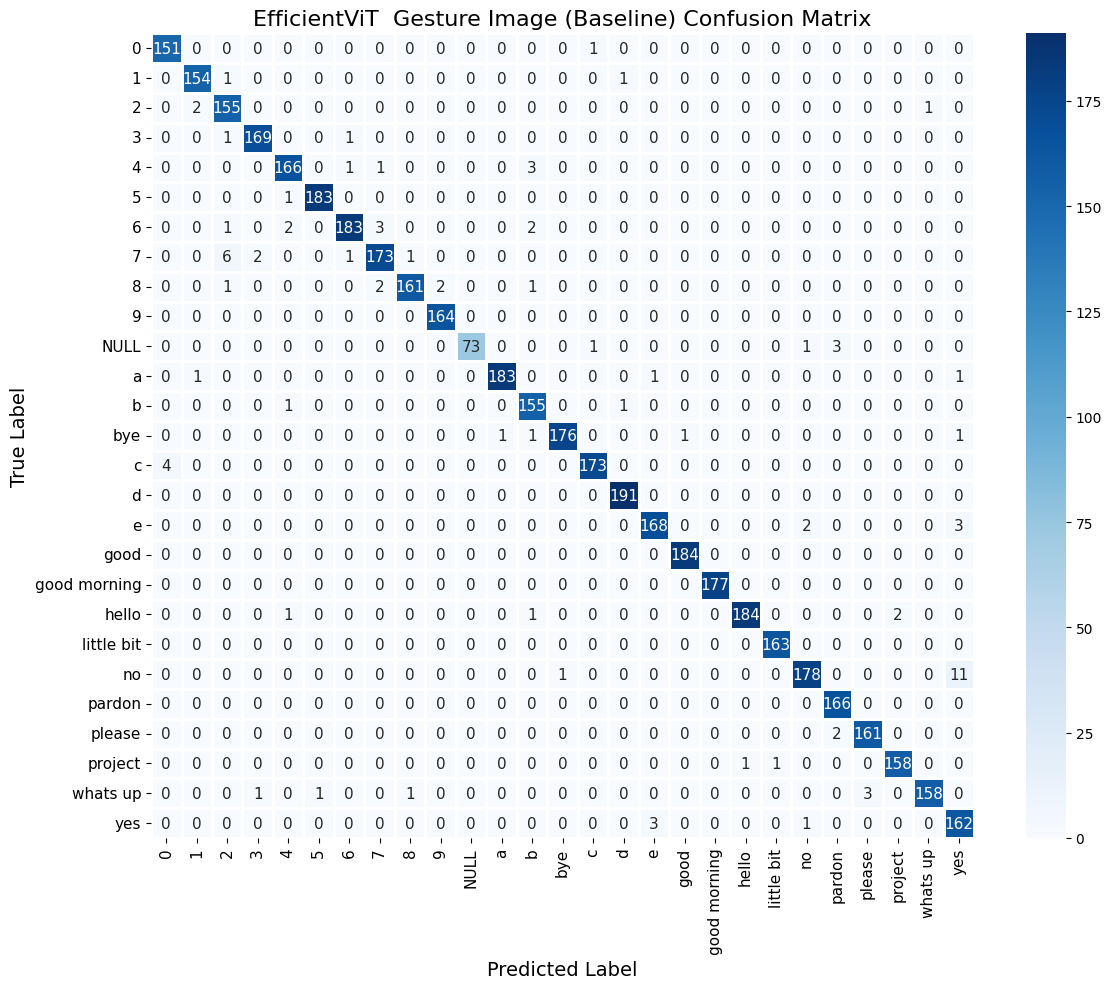

In [30]:
# Plot the confusion matrix with a larger figure size and bigger margins
plt.figure(figsize=(12, 10))  # Adjust the figsize to make the plot larger
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=True,
            annot_kws={"size": 11}, linewidths=1.8)  # Increase linewidth for better visibility of borders
plt.title("EfficientViT  Gesture Image (Baseline) Confusion Matrix", fontsize=16)  # Increase font size of the title
plt.xlabel("Predicted Label", fontsize=14)  # Increase font size of the x-axis label
plt.ylabel("True Label", fontsize=14)  # Increase font size of the y-axis label
plt.xticks(fontsize=11)  # Set x-tick font size
plt.yticks(fontsize=11)

# Adjust the padding around the plot and labels
plt.subplots_adjust(left=0.2, right=0.8, top=0.85, bottom=0.15)  # Adjust the plot margins
plt.tight_layout()  # Ensure everything fits nicely within the plot area
plt.show()

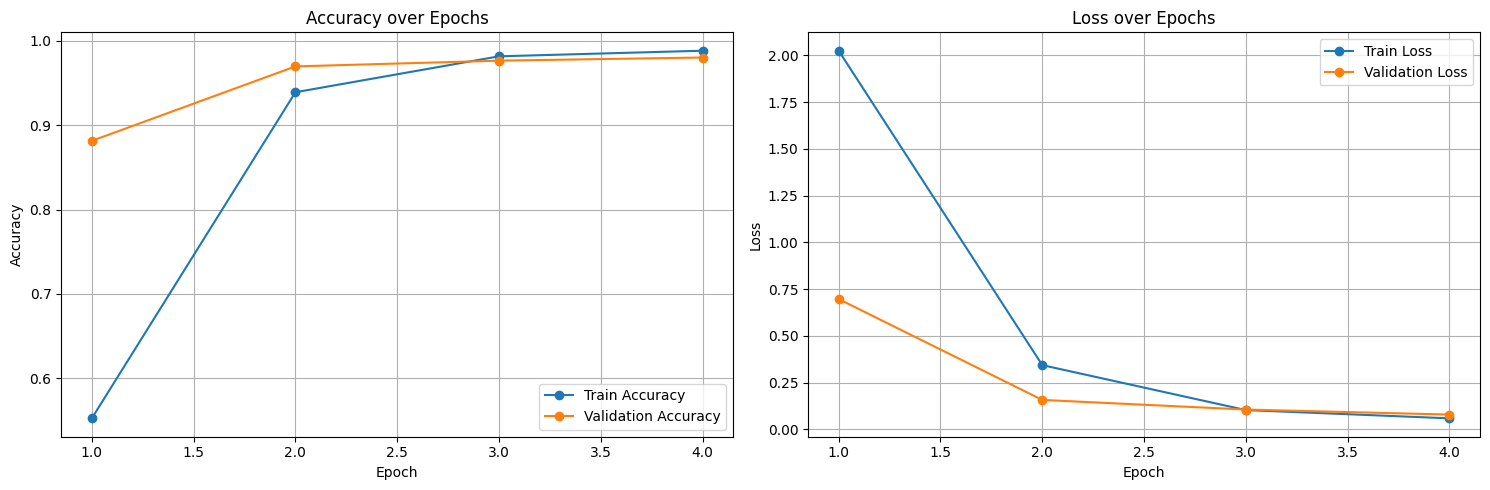

In [31]:
import matplotlib.pyplot as plt

# Create subplots: one for accuracy and one for loss
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot train and validation accuracy
axes[0].plot(range(1, len(train_accuracies) + 1), train_accuracies, marker='o', label="Train Accuracy")
axes[0].plot(range(1, len(val_accuracies) + 1), val_accuracies, marker='o', label="Validation Accuracy")
axes[0].set_title("Accuracy over Epochs")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].grid(True)
axes[0].legend()

# Plot train and validation loss
axes[1].plot(range(1, len(train_losses) + 1), train_losses, marker='o', label="Train Loss")
axes[1].plot(range(1, len(val_losses) + 1), val_losses, marker='o', label="Validation Loss")
axes[1].set_title("Loss over Epochs")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].grid(True)
axes[1].legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

In [32]:
test_loss, test_accuracy = trainer.evaluate(test_loader_resized)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Validating: 100%|██████████| 36/36 [00:05<00:00,  6.32batch/s]

Test Loss: 0.0783, Test Accuracy: 0.9838
